In [2]:
from pipeline import pipeline
from chris import ldData, mlpClassification, makeTrainValSet, balanceStupid, NO_DISPLAY_savePred
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
from heinrich import inv, crop, ecgExtract, rfClassification
from anova import anova

# Evaluate Model



[Pipeline] This is no new run. It already exists at location ./cache/ldData()_crop(300)_inv(0.6)_ecgExtract()_makeTrainValSet(0.1)_mlpClassification(200,True,False).pkl. Returning data_dict anyways.
train losses
val losses


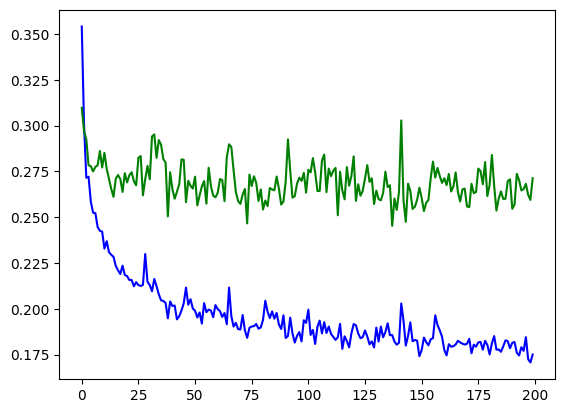

In [5]:
hyper = { 
    
    "inv_threshold": 0.6, 
    "crop_location": 300,
    "mlpClassification_epochs": 200,
    "mlpClassification_useValidationSet": True,
    "mlpClassification_makePrediction": False,
    "makeTrainValSet_valPercent": 0.1,
    "rfClassification_depth": 3,
    "rfClassification_useValidationSet": True,
    "rfClassification_makePrediction": False,
    "anova_percentage": 0.7
}

data = pipeline([ ldData, crop, inv, ecgExtract, makeTrainValSet, mlpClassification ], hyper )
print( "train losses" )
plt.plot( data[ "train_losses" ], color = "blue" )
print( "val losses" )
plt.plot( data[ "val_losses" ], color = "green" )

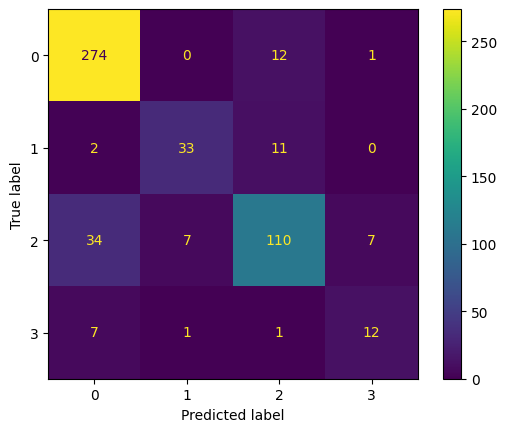

In [4]:
from olin_utils import confMat
_, misclass = confMat( data[ "y_val_hat" ], np.transpose( data[ "y_val" ])[ 0 ], visualize = True )

# Predict

[Pipeline] Saved state found: ./cache/ldData()_crop(300)_inv(0.6)_ecgExtract()_anova(0.7), starting from function: rfClassification
[Pipeline] executing: rfClassification(3,False,True)


/usr/local/share/miniconda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[Pipeline] executing: NO_DISPLAY_savePred()
train losses


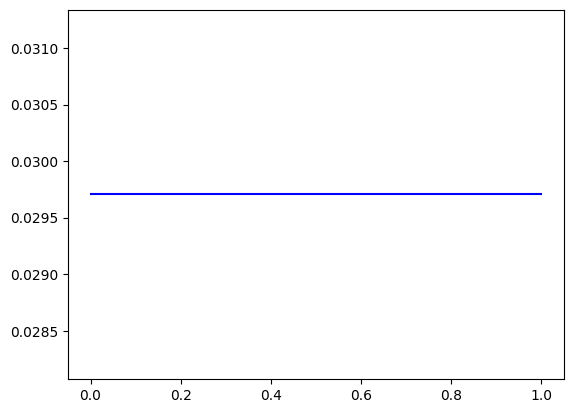

In [17]:
hyper = { 
    
    "inv_threshold": 0.6, 
    "crop_location": 300,
    "mlpClassification_epochs": 150,
    "mlpClassification_useValidationSet": False,
    "mlpClassification_makePrediction": True,
    "makeTrainValSet_valPercent": 0.1,
    "rfClassification_depth": 3,
    "rfClassification_useValidationSet": False,
    "rfClassification_makePrediction": True,
    "anova_percentage": 0.7
}

data = pipeline([ ldData, crop, inv, ecgExtract, anova, rfClassification, NO_DISPLAY_savePred ], hyper )
print( "train losses" )
plt.plot( data[ "train_losses" ], color = "blue" )

In [29]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
from tqdm import tqdm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TrainDataset(Dataset):
    def __init__(self, argX, argy, mean=None, std=None):
        argX = argX.astype(np.float32)
        assert argX.shape[1] % 180 == 0
        self.conv_parallels = int(argX.shape[1]/180)

        if mean is None or std is None:
            self.mean_X = np.mean(argX, axis=0)
            self.std_X = np.std(argX, axis=0)
        else:
            self.mean_X = mean
            self.std_X = std
        self._x = (argX-self.mean_X)/self.std_X

        assert np.isnan(self._x).any() == False

        self._x=self._x.reshape(-1,self.conv_parallels,180)

        self._x = torch.from_numpy(self._x)

        self._y = torch.from_numpy(argy)
        #print(self._y)
        assert self._y.shape[1]==1
        assert not torch.is_floating_point(self._y)
        self._y = torch.nn.functional.one_hot(self._y.unsqueeze(0).to(torch.int64), num_classes = 4).reshape(-1,4).float()

        assert self._x.shape[0] > 0
        assert self._x.shape[0] == self._y.shape[0]

         
    def __len__(self):
        return self._x.shape[0]
    
    def __getitem__(self, idx):
        return self._x[idx], self._y[idx]
    
class TestDataset(TrainDataset):
    def __init__(self, argX, mean, std):
        assert argX.shape[1] == 360
        self.conv_parallels = int(argX.shape[1]/180)
        
        argX = argX.astype(np.float32)

        self._x = (argX-mean)/std

        assert np.isnan(self._x).any() == False
        self._x=self._x.reshape(-1,self.conv_parallels,180)

        self._x = torch.from_numpy(self._x)
        #print(self._y)
        assert self._x.shape[0] > 0

    def __len__(self):
        return self._x.shape[0]
    
    def __getitem__(self, idx):
        return self._x[idx]
    

#X = np.arange(4*720).reshape(-1,720)
#y = np.arange(4).reshape(-1,1)

#t = TrainDataset(X,y)

#t[0][0].shape
#no

In [ ]:

class MLP(nn.Module):
    def __init__(self, parallels):
        super(MLP, self).__init__()
        firstStage = []
        for i in range(parallels)
            firstStage.append(self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']))
        self.classifier = nn.Linear(512, 4)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 2
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool1d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv1d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm1d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool1d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



In [ ]:



def soft_f1_loss(y, y_hat):
    tp = torch.sum(y_hat * y, dim=1)
    fp = torch.sum(y_hat * (1 - y), dim=1)
    fn = torch.sum((1 - y_hat) * y, dim=1)
    
    precision = tp/(tp+fp)
    recall = tp/(fn+tp)

    soft_f1 = 2*precision*recall/(precision+recall+1e-16)

    return torch.mean(1 - soft_f1)
    
def _predict(model, X, mean, std):
    test_set  = TestDataset(X, mean, std)
    test_loader  = DataLoader(test_set,  batch_size=X.shape[0], shuffle=False)
    model.eval()
    with torch.no_grad():
        for x in test_loader:
            x = x.to(device).float()
            predictions = model(x).detach().cpu().numpy()
            return np.argmax(predictions, axis=1)

def train(epochs, X_train, y_train, X_val, y_val, batch_size=32):
    train_set = TrainDataset(X_train, y_train)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    train_X_mean = train_set.mean_X
    train_X_std = train_set.std_X

    if X_val is not None:
        val_set = TrainDataset(X_val, y_val, train_X_mean, train_X_std)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)


    model = MLP(X_train.shape[1]).to(device)

    optimizer = torch.optim.Adam(model.parameters())
    #criterion = nn.CrossEntropyLoss()
    #mse_loss = nn.MSELoss()
    #print(model)

    
    val_loss_timeseries = []
    train_loss_timeseries = []

    for epoch in tqdm(range(epochs)):
        losses = []
        model.train()
        for batch_num, input_data in enumerate(train_loader):
            optimizer.zero_grad()
            x, y = input_data
            x = x.to(device).float()
            y = y.to(device)

            output = model(x)
            #print(output.shape)
            #print(y.shape)
            loss = soft_f1_loss(y, output)
            #loss = mse_loss(output, y)
            #print(loss)
            loss.backward()
            losses.append(loss.item())

            optimizer.step()
        train_loss_timeseries.append(sum(losses)/len(losses))
        
            #if batch_num % 4 == 0:
                #print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
        #print('--- TRAINING Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))
        if X_val is not None:
            valid_losses = []
            model.eval()     # Optional when not using Model Specific layer
            for input_data in val_loader:
                x, y = input_data
                x = x.to(device).float()
                y = y.to(device)


                output = model(x)
                loss = soft_f1_loss(y, output)
                valid_losses.append(loss.item())
            #print('--- VALIDATION Epoch %d | Loss %6.5f' % (epoch, sum(valid_losses)/len(valid_losses)))
            #print("")
            val_loss_timeseries.append(sum(valid_losses)/len(valid_losses))
            

    #plt.semilogy(range(epochs),val_loss_timeseries)
    #plt.show()

    predict_funct = lambda X: _predict(model, X, train_X_mean, train_X_std)

    if X_val is not None:
        return train_loss_timeseries, val_loss_timeseries, predict_funct
    else:
        return train_loss_timeseries, predict_funct